# Load data

In [21]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()


sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_3.csv', 'sample_4.csv']
data = {}

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    data[folder.name] = {}
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')  # handles BOM if present
            # Normalize column names: strip spaces and BOM, unify case
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder.name][sample_file] = df


# Containers for data and weights
data = {}
weights = {}

# Helper function to read weights.txt into a dictionary
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# First, load healthy dataset weights for delta comparison
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Now process all folders
for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    data[folder_name] = {}
    weights[folder_name] = {}
    
    # Read weights
    weight_file = folder / "weights.txt"
    if weight_file.exists():
        current_weights = read_weights(weight_file)
        for sample_file in sample_files:
            if sample_file in current_weights:
                delta = current_weights[sample_file] - healthy_weights.get(sample_file, 0.0)
                weights[folder_name][sample_file] = delta
    
    # Read sample data
    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)
            data[folder_name][sample_file] = df


In [22]:
import pandas as pd
from pathlib import Path

base_folder = Path.cwd()
sample_files = ['sample_1.csv', 'sample_2.csv', 'sample_4.csv']

# Read weights.txt helper
def read_weights(file_path):
    w = {}
    with open(file_path, 'r') as f:
        for line in f:
            if ";" in line:
                key, value = line.strip().split(";")
                key = key.strip().lower().replace("sample", "sample_") + ".csv"
                value = float(value.strip().replace("grams", "").strip())
                w[key] = value
    return w

# Load healthy weights
healthy_folder = base_folder / "healthydataset"
healthy_weights = read_weights(healthy_folder / "weights.txt")

# Collect all sample data into a flat DataFrame
rows = []

for folder in [f for f in base_folder.iterdir() if f.is_dir()]:
    folder_name = folder.name
    weight_file = folder / "weights.txt"
    current_weights = read_weights(weight_file) if weight_file.exists() else {}

    for sample_file in sample_files:
        file_path = folder / sample_file
        if file_path.exists():
            # Load data
            df = pd.read_csv(file_path, encoding='utf-8-sig')
            df.columns = df.columns.str.strip().str.replace('\ufeff', '', regex=True)

            # Delta weight
            delta_weight = current_weights.get(sample_file, None)
            if sample_file in healthy_weights and delta_weight is not None:
                delta_weight -= healthy_weights.get(sample_file, 0.0)

            # Store each row with metadata
            for _, row in df.iterrows():
                row_data = row.to_dict()
                row_data['folder'] = folder_name
                row_data['sample_file'] = sample_file
                row_data['delta_weight'] = delta_weight
                rows.append(row_data)

# Final DataFrame for easy analysis
combined_data = pd.DataFrame(rows)


In [3]:
def get_sample_data(folder_name, sample_file):
    """
    Returns a DataFrame for a specific folder and sample,
    including the delta weight as a column.
    """
    df = combined_data[
        (combined_data['folder'] == folder_name) &
        (combined_data['sample_file'] == sample_file)
    ].copy()
    
    # Optionally, add a single value column for delta_weight if you want it separate
    if not df.empty:
        df['delta_weight'] = df['delta_weight'].iloc[0]
    
    return df


In [27]:
combined_data

,Frequency (Hz),Resistance (ohms),Reactance (ohms),folder,sample_file,delta_weight
0,18000.0000,91.470456,-3694.312106,2024-08-22-Dmg1,sample_1.csv,-0.7
1,18010.0125,93.079092,-3693.988117,2024-08-22-Dmg1,sample_1.csv,-0.7
2,18020.0250,91.379406,-3691.353235,2024-08-22-Dmg1,sample_1.csv,-0.7
3,18030.0375,91.781070,-3689.187713,2024-08-22-Dmg1,sample_1.csv,-0.7
4,18040.0500,91.391648,-3686.528753,2024-08-22-Dmg1,sample_1.csv,-0.7
...,...,...,...,...,...,...
801250,399976.5875,36.562952,-183.123208,HealthyDataset,sample_4.csv,0.0
801251,399986.6000,36.565329,-183.112806,HealthyDataset,sample_4.csv,0.0
801252,399996.6125,36.554457,-183.098934,HealthyDataset,sample_4.csv,0.0
801253,400006.6250,36.548550,-183.084672,HealthyDataset,sample_4.csv,0.0


# PLOT DATA

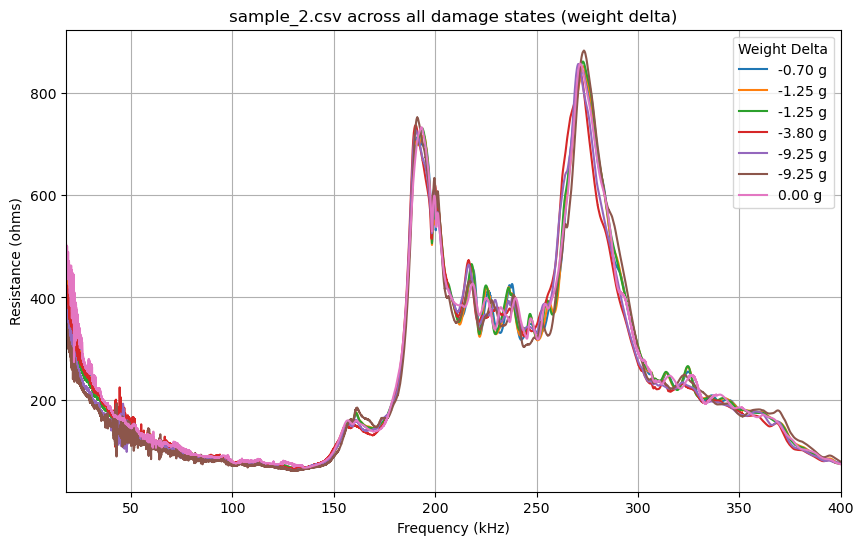

In [24]:
import matplotlib.pyplot as plt

sample_to_plot = "sample_2.csv"

plt.figure(figsize=(10, 6))

for folder_name, samples in data.items():
    if sample_to_plot in samples:
        df = samples[sample_to_plot]
        # Get the delta weight label, format nicely (e.g. 2 decimals)
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        label = f"{delta_weight:.2f} g" if delta_weight is not None else folder_name
        
        plt.plot(
            df["Frequency (Hz)"]/1000,
            df["Resistance (ohms)"],
            label=label
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Resistance (ohms)")
plt.title(f"{sample_to_plot} across all damage states (weight delta)")
plt.legend(title="Weight Delta")
plt.grid(True)
plt.xlim(18,400)
plt.show()



# RMSD and CCD functions

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def compute_rmsd_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Resistance (ohms)"].values[mask])

    rmsd_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Resistance (ohms)"].values[mask])
        rmsd = np.sqrt(np.mean((Z - Z_ref) ** 2))
        rmsd_list.append(rmsd)
        plt.plot(freqs_kHz, Z, label=str(label[i]))


    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Resistance")
    plt.title("Normalized Resistance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(rmsd_list)


## Test RMSD

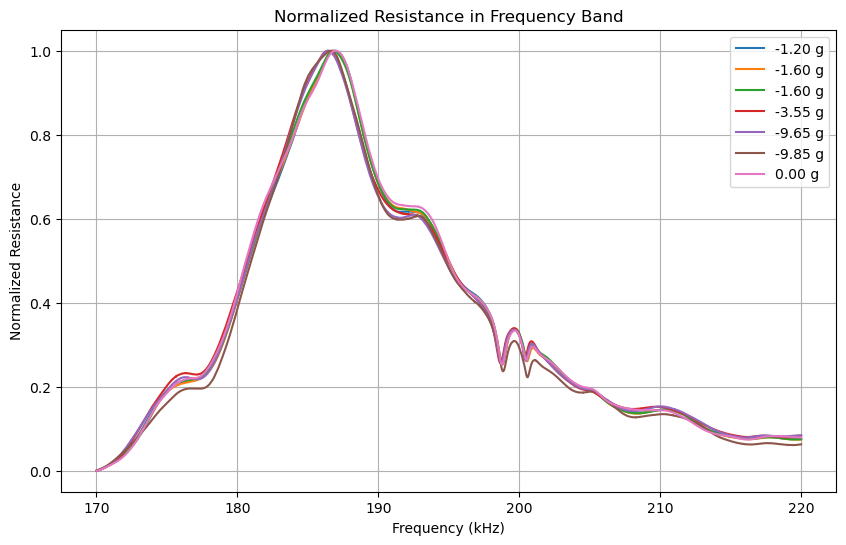

[0.00864092 0.00829435 0.00823307 0.01835886 0.0203941  0.0254352
 0.        ]


In [6]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(rmsd_values)

## CCD Function

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_corr_dev_from_dfs_simple(dfs, f_min, f_max, label):
    freqs = dfs[0]["Frequency (Hz)"].values
    mask = (freqs >= f_min) & (freqs <= f_max)
    freqs_kHz = freqs[mask] / 1000

    def normalize(arr):
        return (arr - arr.min()) / (arr.max() - arr.min())

    Z_ref = normalize(dfs[-1]["Resistance (ohms)"].values[mask])

    corr_dev_list = []
    plt.figure(figsize=(10, 6))
    for i, df in enumerate(dfs):
        Z = normalize(df["Resistance (ohms)"].values[mask])
        corr_coef = np.corrcoef(Z, Z_ref)[0, 1]  # Pearson correlation coefficient
        corr_dev = 1 - corr_coef
        corr_dev_list.append(corr_dev)
        plt.plot(freqs_kHz, Z, label=str(label[i]))

    plt.xlabel("Frequency (kHz)")
    plt.ylabel("Normalized Resistance")
    plt.title("Normalized Resistance in Frequency Band")
    plt.grid(True)
    plt.legend()
    plt.show()

    return np.array(corr_dev_list)

## Test CCD Function

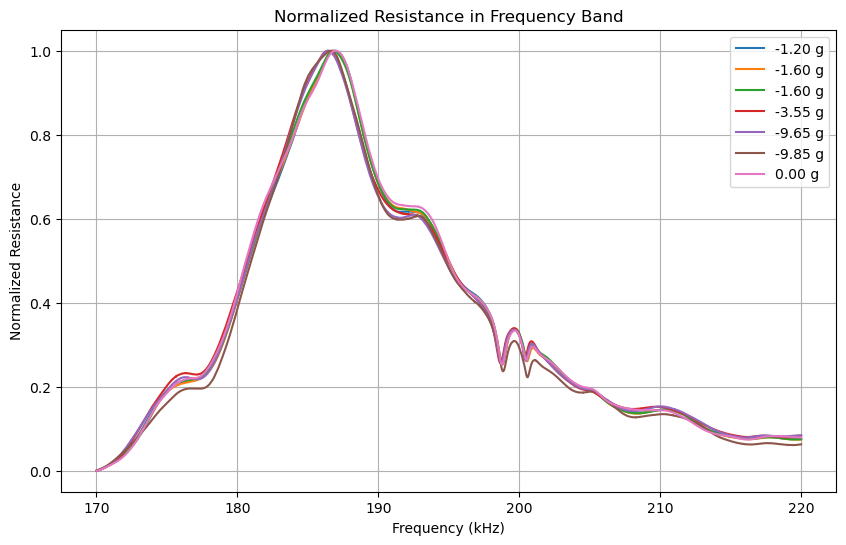

[3.58512397e-04 2.98855714e-04 3.75946416e-04 2.05212775e-03
 2.27481207e-03 2.59802349e-03 2.22044605e-16]


In [8]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

print(CCD_values)

## Get RMSD and CCD

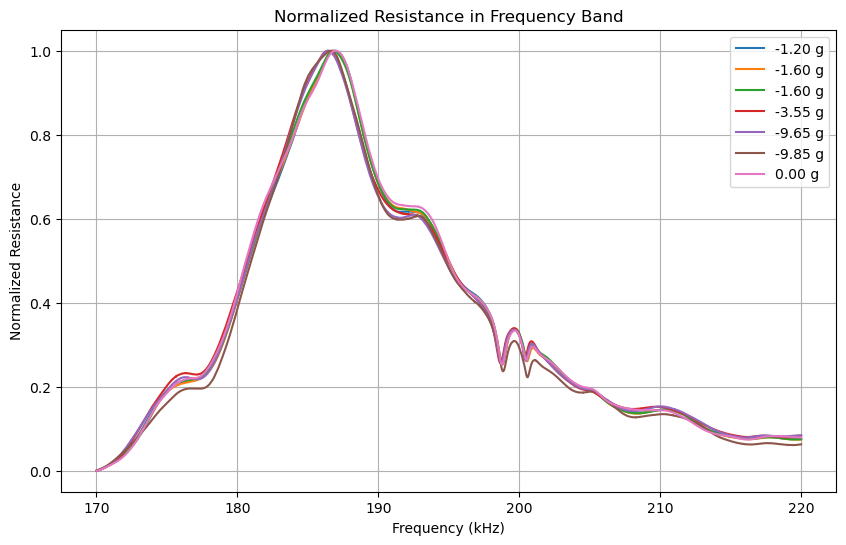

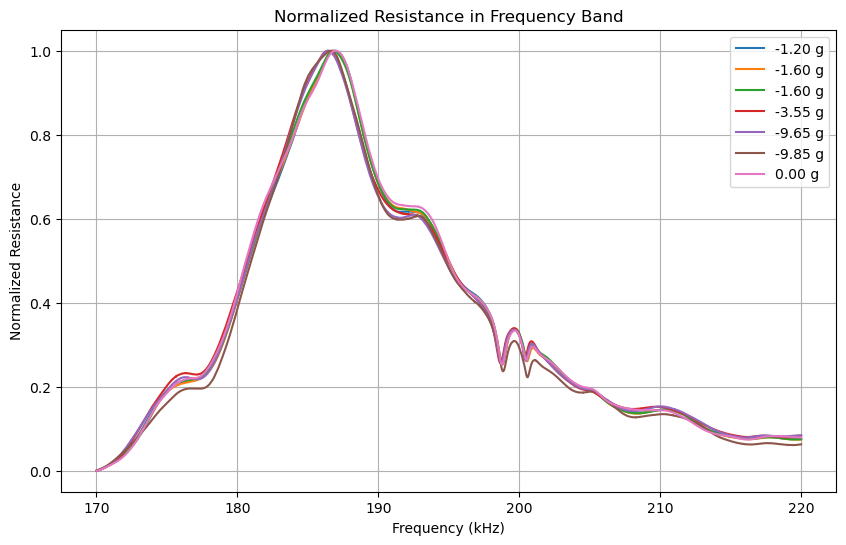

In [9]:
sample_to_plot = "sample_4.csv"
f_min, f_max = 170000, 220000

dfs_for_sample = [
    samples[sample_to_plot]
    for folder_name, samples in data.items()
    if sample_to_plot in samples
]

labels = []
for folder_name, samples in data.items():
    if sample_to_plot in samples:
        delta_weight = weights.get(folder_name, {}).get(sample_to_plot, None)
        if delta_weight is not None:
            labels.append(f"{delta_weight:.2f} g")
        else:
            labels.append(folder_name)

rmsd_values = compute_rmsd_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

CCD_values = compute_corr_dev_from_dfs_simple(dfs_for_sample, f_min, f_max, labels)

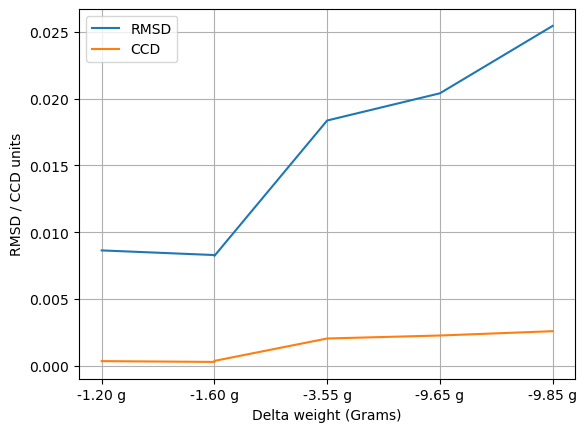

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot all except the last value which is the original, healthy dataset
ax1.plot(labels[:-1], rmsd_values[:-1], label='RMSD')
ax1.plot(labels[:-1],CCD_values[:-1], label='CCD')
ax1.set_ylabel('RMSD / CCD units')
ax1.legend(loc='upper left')
ax1.set_xlabel('Delta weight (Grams)')
plt.grid()
plt.show()


# BVD

In [62]:
import numpy as np
import matplotlib.pyplot as plt

f_band = sample4["Frequency (Hz)"].values
Z_meas_band = sample4["Resistance (ohms)"].values

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


f = np.linspace(18e3, 400e3, 50000)
Z1 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"], param_guesses["L1"], param_guesses["C0"])
Z2 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"]*1.1, param_guesses["L1"]*1.1, param_guesses["C0"]*1.1)
Z3 = butterworth_van_dyke(f, param_guesses["R1"], param_guesses["C1"]*0.9, param_guesses["L1"]*0.9, param_guesses["C0"]*0.9)

Z = Z1 + Z2 + Z3

plt.figure(figsize=(10,6))
plt.plot(f/1e3, np.real(Z), label='|Z| (Ohms)')
plt.plot(f_band[1:30000]/1e3, Z_meas_band[1:30000], label="Re{Z} measured")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Resistance Magnitude (Ohm)')
plt.title(f'3rd order BVD Model')
plt.grid(True)
plt.legend()
plt.xlim(18, 400)
plt.show()


NameError: name 'sample4' is not defined

## Try to fit BVD model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

f_band = sample4["Frequency (Hz)"].values
Z_meas_real = sample4["Resistance (ohms)"].values
Z_meas_imag = sample4["Reactance (ohms)"].values

Z_meas_band = Z_meas_real +1j * Z_meas_imag

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


f = np.linspace(120e3, 250e3, 50000)
Z1 = butterworth_van_dyke(f, param_guesses["R1"]*1, param_guesses["C1"]*1, param_guesses["L1"]*1, param_guesses["C0"]*1)
Z2 = butterworth_van_dyke(f, param_guesses["R1"]*0.6, param_guesses["C1"]*0.6, param_guesses["L1"]*0.6, param_guesses["C0"]*0.6)
Z3 = butterworth_van_dyke(f, param_guesses["R1"]*1, param_guesses["C1"]*1, param_guesses["L1"]*1, param_guesses["C0"]*1)

Z = Z1 + Z2 + Z3

plt.figure(figsize=(10,6))
plt.plot(f/1e3, np.abs(Z), label='|Z| (Ohms)')
plt.plot(f_band[10000:24000]/1e3, np.abs(Z_meas_band[10000:24000]), label="Re{Z} measured")
plt.xlabel('Frequency (kHz)')
plt.ylabel('Resistance Magnitude (Ohm)')
plt.title(f'3rd order BVD Model')
plt.grid(True)
plt.legend()
plt.xlim(120, 250)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Your measured data
f_band = sample4["Frequency (Hz)"].values
Z_meas_real = sample4["Resistance (ohms)"].values
Z_meas_imag = sample4["Reactance (ohms)"].values
Z_meas_band = Z_meas_real + 1j * Z_meas_imag

# Restrict to the band of interest
idx_low, idx_high = 14000, 20000
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]


def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


def bvd_sum(f, params):
    """3rd order sum of BVD resonators"""
    R1, L1, C1, C0 = params[0:4]
    R2, L2, C2, C02 = params[4:8]
    R3, L3, C3, C03 = params[8:12]
    Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
    Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
    Z3 = butterworth_van_dyke(f, R3, C3, L3, C03)
    return Z1 + Z2

# def bvd_sum(f, params):
#     """3rd order sum of BVD resonators"""
#     R1, L1, C1, C0 = params[0:4]
#     R2, L2, C2, C02 = params[4:8]
#     Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
#     Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
#     return Z1 + Z2


# --- Initial guesses (flattened for optimizer) ---
param_guesses = [
    155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
    155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6,  # resonator 2
    155.0*0.1, 900e-6*0.1, 0.89e-9*0.1, 5.9e-9*0.1   # resonator 3
]

# Define cost function (magnitude fit for now)
def residuals(params, f, Z_meas):
    Z_model = bvd_sum(f, params)
    return np.abs(Z_model) - np.abs(Z_meas)


# Run least squares
result = least_squares(residuals, param_guesses, args=(f_fit, Z_meas_fit))

fitted_params = result.x
print("Fitted parameters:")
print(fitted_params)

# Compute fitted curve
Z_fit = bvd_sum(f_fit, fitted_params)

# Plot results
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.real(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.real(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:


# --- Band of interest ---
idx_low, idx_high = 14000, 20000
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total

def bvd_sum(f, params):
    """3rd order sum of BVD resonators"""
    R1, L1, C1, C0 = params[0:4]
    R2, L2, C2, C02 = params[4:8]
    R3, L3, C3, C03 = params[8:12]
    Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
    Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
    Z3 = butterworth_van_dyke(f, R3, C3, L3, C03)
    return Z1 + Z2 + Z3

# Cost function (fit both real & imag parts)
def residuals(params, f, Z_meas):
    Z_model = bvd_sum(f, params)
    return np.concatenate([
        np.real(Z_model) - np.real(Z_meas),
        np.imag(Z_model) - np.imag(Z_meas)
    ])

# Define search bounds (positive values, reasonable orders of magnitude)
bounds = [
    (1, 1e4),        # R1
    (1e-6, 1e-3),    # L1
    (1e-12, 1e-8),   # C1
    (1e-12, 1e-8),   # C0
    (1, 1e4),        # R2
    (1e-6, 1e-3),    # L2
    (1e-12, 1e-8),   # C2
    (1e-12, 1e-8),   # C02
    (1, 1e4),        # R3
    (1e-6, 1e-3),    # L3
    (1e-12, 1e-8),   # C3
    (1e-12, 1e-8)    # C03
]

def objective(p):
    return np.sum(residuals(p, f_fit, Z_meas_fit)**2)

param_guesses = np.array([
    155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
    155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6,
    155.0*0.1, 900e-6*0.1, 0.89e-9*0.1, 5.9e-9*0.1
])

result_de = differential_evolution(
    objective,
    bounds,
    maxiter=200,
    init=[param_guesses, 'latinhypercube'],  # include your guess + randoms
    workers=1
)


print("Differential evolution result:", result_de.fun)

# --- Step 2: Local refinement ---
result_ls = least_squares(residuals, result_de.x, args=(f_fit, Z_meas_fit))
fitted_params = result_ls.x

print("Fitted parameters:")
print(fitted_params)

# Compute fitted curve
Z_fit = bvd_sum(f_fit, fitted_params)

# Plot
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.abs(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.abs(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# --- Band of interest ---
idx_low, idx_high = 14000, 20000
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total

def bvd_sum(f, params):
    """3rd order sum of BVD resonators"""
    R1, L1, C1, C0 = params[0:4]
    R2, L2, C2, C02 = params[4:8]
    #R3, L3, C3, C03 = params[8:12]
    Z1 = butterworth_van_dyke(f, R1, C1, L1, C0)
    Z2 = butterworth_van_dyke(f, R2, C2, L2, C02)
    #Z3 = butterworth_van_dyke(f, R3, C3, L3, C03)
    return Z1 + Z2

# Cost function (real + imag parts)
def residuals(params, f, Z_meas):
    Z_model = bvd_sum(f, params)
    return np.concatenate([
        np.real(Z_model) - np.real(Z_meas),
        np.imag(Z_model) - np.imag(Z_meas)
    ])

# --- Initial guess (baseline) ---
# param_guesses = np.array([
#     155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
#     155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6,
#     155.0*0.1, 900e-6*0.1, 0.89e-9*0.1, 5.9e-9*0.1
# ])

# --- Initial guess (baseline) ---
param_guesses = np.array([
    155.0, 900e-6, 0.89e-9, 5.9e-9,   # resonator 1
    155.0*0.6, 900e-6*0.6, 0.89e-9*0.6, 5.9e-9*0.6
    ])



# --- Multi-restart least squares ---
best = None
n_trials = 10000  # number of random restarts

for i in range(n_trials):
    # random scaling between 0.5x and 2x for each parameter
    guess = param_guesses * (0.5 + 1.5*np.random.rand(len(param_guesses)))
    res = least_squares(residuals, guess, args=(f_fit, Z_meas_fit))
    if best is None or res.cost < best.cost:
        best = res
        print(f"Trial {i+1}: New best cost = {res.cost:.4e}")

fitted_params = best.x
print("\nBest fitted parameters:")
print(fitted_params)

# Compute fitted curve
Z_fit = bvd_sum(f_fit, fitted_params)

# Plot
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.abs(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.abs(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plot
plt.figure(figsize=(10,6))
plt.plot(f_fit/1e3, np.real(Z_meas_fit), label="Measured |Z|")
plt.plot(f_fit/1e3, np.real(Z_fit), label="Fitted |Z|")
plt.xlabel("Frequency (kHz)")
plt.ylabel("Impedance Magnitude (Ohm)")
plt.title("3rd order BVD Fit (14000:20000 band)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.plot(f_fit/1e3,np.abs(Z_meas_fit))

AntiResonance = f_fit[np.argmin(np.abs(Z_meas_fit))]
Resonance = f_fit[np.argmax(np.abs(Z_meas_fit))]

Q

print(AntiResonance)

In [ ]:
import numpy as np

def bvd_from_specs(f0, Zpeak, Q):
    """
    f0: resonance frequency [Hz]
    Zpeak: peak impedance [Ohms]
    Q: quality factor
    """
    omega0 = 2 * np.pi * f0
    R = Zpeak
    L = R * Q / omega0
    C = 1 / (omega0**2 * L)
    return R, L, C

# Example
f0 = 186000        # 1 kHz
Zpeak = 169       # Ohms
Q = 22.9           # dimensionless

R, L, C = bvd_from_specs(f0, Zpeak, Q)
print("R =", R, "Ohm")
print("L =", L, "H")
print("C =", C, "F")


In [ ]:
import numpy as np
from scipy.signal import find_peaks

def two_dof_peak_analysis(freq, Zmag):
    """
    freq: frequency array
    Zmag: measured magnitude (e.g., |Z|) array
    Returns: list of dictionaries with resonance and antiresonance info:
             [{'f_res':..., 'Z_res':..., 'Q':..., 'f_anti':..., 'Z_anti':...}, ...]
    """
    # Find resonance peaks (impedance maxima)
    peaks, _ = find_peaks(Zmag, height=np.max(Zmag)*1)  # threshold at 10% of max

    # Find antiresonance (impedance minima)
    invZ = -Zmag
    anti_peaks, _ = find_peaks(invZ)
    
    peak_info = []

    for p in peaks:
        Zpeak = Zmag[p]
        fpeak = freq[p]

        # Estimate Q from -3dB points
        half_power = Zpeak / np.sqrt(2)
        # Find left side
        left_idx = p
        while left_idx > 0 and Zmag[left_idx] > half_power:
            left_idx -= 1
        f_left = freq[left_idx]

        # Find right side
        right_idx = p
        while right_idx < len(Zmag)-1 and Zmag[right_idx] > half_power:
            right_idx += 1
        f_right = freq[right_idx]

        BW = f_right - f_left
        Q = fpeak / BW if BW > 0 else np.nan

        # Find nearest antiresonance (impedance minimum) after this resonance
        f_anti, Z_anti = None, None
        candidates = [a for a in anti_peaks if freq[a] > fpeak]
        if candidates:
            a = candidates[0]  # take the first minimum after this peak
            f_anti = freq[a]
            Z_anti = Zmag[a]

        peak_info.append({
            'f_res': fpeak,
            'Z_res': Zpeak,
            'Q': Q,
            'f_anti': f_anti,
            'Z_anti': None
        })

    # Sort by resonance frequency
    peak_info = sorted(peak_info, key=lambda x: x['f_res'])
    return peak_info

# Example usage
freq = np.linspace(900, 1100, 1000)
Zmag = (
    np.abs(np.sin(2*np.pi*(freq-1000)/50)) +
    np.abs(np.sin(2*np.pi*(freq-1020)/30))
)  # overlapping peaks

peaks = two_dof_peak_analysis(freq, Zmag)
for pk in peaks:
    print(pk)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Frequency axis
f = np.linspace(150000, 250000, 50000)

# Two artificial "resonances" (Gaussian bumps, not physical transfer functions)
peak1 = np.exp(-0.0000003 * ((f - 200000)/3)**2)   # centered at 30 Hz
peak2 = np.exp(-0.0000003 * ((f - 210000)/3)**2)   # centered at 70 Hz

# System response = sum of two peaks
H = ((peak1 - peak2) + 1) * 100 + 300

plt.plot(f, H)
plt.title("Artificial System with Two Resonant Peaks")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True)
plt.show()

In [ ]:


def bvd_from_peakinfo(peak_info_list):
    bvd_params = []
    for peak_info in peak_info_list:
        f_res = peak_info['f_res']
        f_anti = peak_info['f_anti']
        Z_res = peak_info['Z_res']
        Q = peak_info['Q']

        if f_res is None or f_anti is None:
            continue  # skip incomplete peaks

        omega_res = 2 * np.pi * f_res

        # Motional branch
        Rm = Z_res
        Lm = Rm * Q / omega_res
        Cm = 1 / (omega_res**2 * Lm)

        # Static capacitance from anti-resonance
        C0 = Cm / ((f_anti/f_res)**2 - 1)

        bvd_params.append({'Rm': Rm, 'Lm': Lm, 'Cm': Cm, 'C0': C0})

    return bvd_params  

def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total

import numpy as np

def bvd_from_complex(freq, Z, f_res, f_anti):
    """
    Compute BVD model parameters from complex impedance data.
    
    freq: frequency array [Hz]
    Z: complex impedance array [Ohm]
    f_res: resonance frequency [Hz] (series resonance)
    f_anti: anti-resonance frequency [Hz]
    
    Returns: dict with Rm, Lm, Cm, C0
    """
    omega_res = 2 * np.pi * f_res
    
    # Interpolate Z at resonance
    Z_res = np.interp(f_res, freq, Z.real) + 1j*np.interp(f_res, freq, Z.imag)
    
    # Motional resistance from real(Z) at resonance
    Rm = np.real(Z_res)
    
    # Estimate Q from bandwidth on reactance zero-crossing
    # Find -3dB points on |Z| near f_res
    Zmag = np.abs(Z)
    idx_res = np.argmin(np.abs(freq - f_res))
    Zpeak = Zmag[idx_res]
    half_power = Zpeak / np.sqrt(2)

    # left half power
    left_idx = idx_res
    while left_idx > 0 and Zmag[left_idx] < half_power:
        left_idx -= 1
    f_left = freq[left_idx]

    # right half power
    right_idx = idx_res
    while right_idx < len(Zmag)-1 and Zmag[right_idx] < half_power:
        right_idx += 1
    f_right = freq[right_idx]

    BW = f_right - f_left
    Q = f_res / BW if BW > 0 else np.nan

    # Motional branch Lm, Cm
    Lm = Rm * Q / omega_res
    Cm = 1 / (omega_res**2 * Lm)

    # Static capacitance C0 from antiresonance
    C0 = Cm / ((f_anti/f_res)**2 - 1)

    return {'Rm': Rm, 'Lm': Lm, 'Cm': Cm, 'C0': C0, 'Q': Q}



In [ ]:

# Example usage
#peakdata = two_dof_peak_analysis(f, H)
peakdata = two_dof_peak_analysis(f_fit,Z_meas_fit)


print(peakdata[0])
params = bvd_from_peakinfo(peakdata[0])

R1 = params['Rm']
C1 = params['Cm']
L1 = params['Lm']
C0 = params['C0']

print("Rm =", params['Rm'])
print("Lm =", params['Lm'])
print("Cm =", params['Cm'])
print("C0 =", params['C0'])
print("Q  =", params['Q'])


Z = butterworth_van_dyke(f_fit, R1, C1, L1, C0)

# plt.plot(f, H)
plt.plot(f_fit,np.abs(Z_meas_fit))

#plt.plot(f_fit,np.abs(Z))

# --- Initial guesses ---
param_guesses = {
    'R1': 155.0,         # Ohm
    'L1': 900e-6,        # H
    'C1': 0.89e-9,       # F
    'C0': 5.9e-9         # F
}


In [ ]:
import numpy as np

def bvd_from_peakinfo(peak_info_list):
    """
    Convert peak analysis output into BVD model parameters.
    
    peak_info_list: list of dicts (output of two_dof_peak_analysis)
    
    Returns: list of dicts with Rm, Lm, Cm, C0 for each resonance
    """
    bvd_params = []
    for peak_info in peak_info_list:
        f_res = np.real(peak_info['f_res'])
        f_anti = np.real(peak_info['f_anti'])
        Z_res = np.real(peak_info['Z_res'])
        Q = np.real(peak_info['Q'])

        if f_res is None or f_anti is None:
            continue  # skip incomplete peaks

        omega_res = 2 * np.pi * f_res

        # Motional branch
        Rm = Z_res
        Lm = Rm * Q / omega_res
        Cm = 1 / (omega_res**2 * Lm)

        # Static capacitance from anti-resonance
        C0 = Cm / ((f_anti/f_res)**2 - 1)

        bvd_params.append({'Rm': Rm, 'Lm': Lm, 'Cm': Cm, 'C0': C0})

    return bvd_params


peakdata = two_dof_peak_analysis(f_fit, np.abs(Z_meas_fit))



# peakdata = [
#     {'f_res': 186000, 'Z_res': 169, 'Q': 22.9, 'f_anti': 188000, 'Z_anti': None}]

# peakdata =[
#     # Example usage
# {'f_res': 186920.7625, 'Z_res': 169.66578999332685, 'Q': 22.96278022705319, 'f_anti': 186940.7875, 'Z_anti': None}
# ]

params = bvd_from_peakinfo(peakdata)
for p in params:
    print(p)

R1 = params[0]['Rm']
C1 = params[0]['Cm']
L1 = params[0]['Lm']
C0 = params[0]['C0']

Z = butterworth_van_dyke(f_fit, R1, C1, L1, C0)

# plt.plot(f, H)
plt.plot(f_fit,np.real(Z))
plt.plot(f_fit,np.real(Z_meas_fit))



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Measured data (must be defined outside this snippet)
# f_fit: frequency array in Hz
# Z_meas_fit: measured complex impedance
f_fit = f_fit  # <-- replace with your frequency array
Z_meas = Z_meas_fit

# BVD impedance model
def butterworth_van_dyke(f, Rm, Cm, Lm, C0):
    w = 2 * np.pi * f
    Zm = Rm + 1j*w*Lm + 1/(1j*w*Cm)
    Y_total = 1j*w*C0 + 1/Zm
    return 1 / Y_total


def residuals(params, f, Z_meas):
    R1, C1, L1, C0 = params
    Z_model = butterworth_van_dyke(f, R1, C1, L1, C0)
    res_real = (Z_model.real - Z_meas.real) / np.max(np.abs(Z_meas.real))
    res_imag = (Z_model.imag - Z_meas.imag) / np.max(np.abs(Z_meas.imag))
    return np.concatenate([res_real, res_imag])


# Initial guess: [R1, C1, L1, C0]
R1 = 600
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0 = 2.5e-9

initial_guess = [R1,C1, L1, C0]

# Perform fit
lower = [200, 1e-11, 1e-7, 1e-15]   # R, C1, L, C0
upper = [1e4, 1e-9, 1e-2, 1e-6]

result = least_squares(
    residuals, 
    initial_guess, 
    args=(f_fit, Z_meas),
    bounds=(lower, upper),
    method="trf",
    ftol=1e-15, xtol=1e-15, gtol=1e-15,
    max_nfev=10000
)


R1_fit, C1_fit, L1_fit, C0_fit = result.x

print("Fit cost:", result.cost)
print("Fitted params:")
print("R1 =", R1_fit)
print("C1 =", C1_fit)
print("L1 =", L1_fit)
print("C0 =", C0_fit)


# Evaluate fitted impedance
fitted_Z = butterworth_van_dyke(f_fit, R1_fit, C1_fit, L1_fit, C0_fit)

Initial_fitted_Z = butterworth_van_dyke(f_fit, R1, C1, L1, C0)


# Plot measured vs fitted real part
plt.figure()
plt.plot(f_fit, np.real(Z_meas), label="Measured Re(Z)")
plt.plot(f_fit, np.real(fitted_Z), '--', label="Fitted Re(Z)")
plt.plot(f_fit, np.real(Initial_fitted_Z), '--', label="Initial Fitted Re(Z)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Resistance (Ohm)")
plt.show()


In [ ]:
# BVD impedance model
def TwoDOF_butterworth_van_dyke(f, R1, C1, L1, C0_1, R2, C2, L2, C0_2):
    w = 2 * np.pi * f
    Z1 = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y1 = 1j*w*C0_1 + 1/Z1

    Z2 = R2 + 1j*w*L2 + 1/(1j*w*C2)
    Y2 = 1j*w*C0_2 + 1/Z2
    return 1 / (Y1+Y2)

# Initial guess: [R1, C1, L1, C0]
R1 = 600
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 200
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9


Ztest = TwoDOF_butterworth_van_dyke(f_fit, R1, C1, L1, C0_1, R2, C2, L2, C0_2)

# Plot measured vs fitted real part
plt.figure()
plt.plot(f_fit, np.real(Ztest), label="Measured Re(Z)")
plt.plot(f_fit, np.real(Z_meas), label="Measured Re(Z)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Resistance (Ohm)")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Measured data (must be defined outside this snippet)
# f_fit: frequency array in Hz
# Z_meas_fit: measured complex impedance
f_fit = f_fit  # <-- replace with your frequency array
Z_meas = Z_meas_fit

# BVD impedance model
def TwoDOF_butterworth_van_dyke(f, R1, C1, L1, C0_1, R2, C2, L2, C0_2):
    w = 2 * np.pi * f
    Z1 = R1 + 1j*w*L1 + 1/(1j*w*C1)
    Y1 = 1j*w*C0_1 + 1/Z1

    Z2 = R2 + 1j*w*L2 + 1/(1j*w*C2)
    Y2 = 1j*w*C0_2 + 1/Z2
    return 1 / (Y1+Y2)


def residuals(params, f, Z_meas):
    R1, C1, L1, C0_1, R2, C2, L2, C0_2 = params
    Z_model = TwoDOF_butterworth_van_dyke(f, R1, C1, L1, C0_1, R2, C2, L2, C0_2)
    res_real = (Z_model.real - Z_meas.real) / np.max(np.abs(Z_meas.real))
    res_imag = (Z_model.imag - Z_meas.imag) / np.max(np.abs(Z_meas.imag))
    return np.concatenate([1*res_real, 100*res_imag])  # emphasize real part



# Initial guess: [R1, C1, L1, C0]
R1 = 550
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 150
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9

initial_guess = [R1,C1, L1, C0_1, R2, C2, L2, C0_2]

# Perform fit
lower = [200, 1e-11, 1e-7, 1e-15,
          1, 1e-15, 1e-10, 1e-15]   # R, C1, L, C0

upper = [1e3, 1e-9, 1e-2, 1e-6,
          1e3, 1e-9, 1e-1, 1e-3]

result = least_squares(
    residuals, 
    initial_guess, 
    args=(f_fit, Z_meas),
    bounds=(lower, upper),
    method="trf",
    ftol=1e-15, xtol=1e-15, gtol=1e-15,
    max_nfev=10000
)

R1_fit, C1_fit, L1_fit, C0_1_fit, R2_fit, C2_fit, L2_fit, C0_2_fit = result.x

print("Fit cost:", result.cost)
print("Fitted params:")
print("R1 =", R1_fit)
print("C1 =", C1_fit)
print("L1 =", L1_fit)
print("C0 =", C0_1_fit)
print("R2 =", R2_fit)
print("C2 =", C2_fit)
print("L2 =", L2_fit)
print("C0_2 =", C0_2_fit)


# Evaluate fitted impedance
fitted_Z = TwoDOF_butterworth_van_dyke(f_fit, R1_fit, C1_fit, L1_fit, C0_fit, R2_fit, C2_fit, L2_fit, C0_2_fit)
Initial_fitted_Z = TwoDOF_butterworth_van_dyke(f_fit, R1, C1, L1, C0, R2, C2, L2, C0_2)

# Plot measured vs fitted real part
plt.figure()
plt.plot(f_fit, np.real(Z_meas), label="Measured Re(Z)")
plt.plot(f_fit, np.real(fitted_Z), '--', label="Fitted Re(Z)")
plt.plot(f_fit, np.real(Initial_fitted_Z), '--', label="Initial Fitted Re(Z)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Resistance (Ohm)")
plt.show()


# Genetic fitting algorithm

## Get data

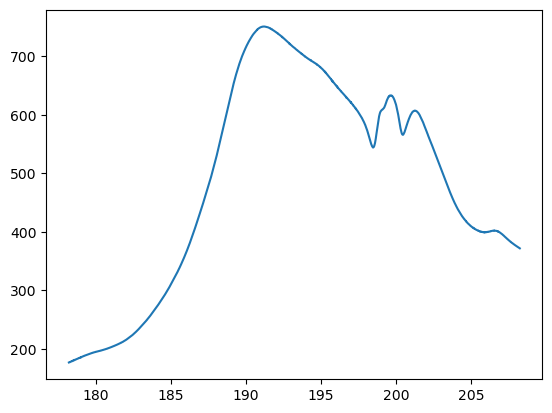

In [63]:
def get_sample_data(folder_name, sample_file):
    """
    Returns a DataFrame for a specific folder and sample,
    including the delta weight as a column.
    """
    df = combined_data[
        (combined_data['folder'] == folder_name) &
        (combined_data['sample_file'] == sample_file)
    ].copy()
    
    # Optionally, add a single value column for delta_weight if you want it separate
    if not df.empty:
        df['delta_weight'] = df['delta_weight'].iloc[0]
    
    return df

# Example usage
folder_name = "2024-09-19-Dmg6"
sample_file = "sample_2.csv"
idx_low, idx_high = 14000, 20000 # For sample 4
idx_low, idx_high = 16000, 19000 # For sample 2



sample_data = get_sample_data(folder_name, sample_file)

f_band = sample_data["Frequency (Hz)"].values
Z_meas_real =  sample_data["Resistance (ohms)"].values
Z_meas_imag =  sample_data["Reactance (ohms)"].values

Z_meas_band = Z_meas_real + 1j*Z_meas_imag

# Restrict to the band of interest
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]

plt.plot(f_fit/1e3, np.real(Z_meas_fit), label="Measured |Z|")


## Get simulated data

<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
C:\Users\au585732\AppData\Local\Temp\ipykernel_33980\2942724243.py:22: SyntaxWarning: invalid escape sequence '\D'
  Simulated_meta_Data = pd.read_excel("Simulated_dataset\DAMAGE CASES by Kasper.xlsx")


Loaded 27 samples
Z_meas_samples[0] shape: (50,)


c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


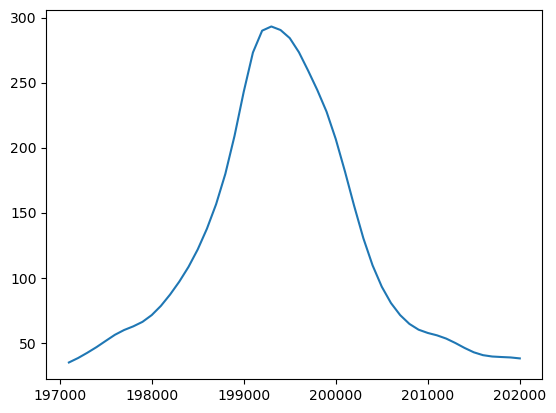

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------
# Load all Excel files
# ---------------------------
sim_base_path = Path("Simulated_dataset") / "UniformCorrosion"
sample_files = list(sim_base_path.glob("*.xlsx"))

mass_rod = 200
V_rod = 16

#Compute mass loss 
def compute_mass_loss(row):
    L_cor = row['General corrosion: length of corrosion area [mm]'] 
    D_cor = row['General corrosion: Corrosion diameter [mm]'] 
    V_cor = np.pi * (D_cor/2)**2 * L_cor 
    return mass_rod * V_cor / V_rod

Simulated_meta_Data = pd.read_excel("Simulated_dataset\DAMAGE CASES by Kasper.xlsx")

simulated_mass_loss = compute_mass_loss(Simulated_meta_Data)

# Frequency band indices
idx_low, idx_high = 70, 120

sample_weights = []
Z_meas_samples = []

for i, file in enumerate(sample_files):
    df = pd.read_excel(file)

    # Map your column names to what the pipeline expects
    f_band = df["Frequency (Hz)"].values
    Z_meas_real = df["Real (Ohm)"].values
    Z_meas_imag = df["Imaginary (Ohm)"].values

    # Complex impedance
    Z_meas_band = Z_meas_real + 1j * Z_meas_imag

    # Restrict to frequency band
    f_fit = f_band[idx_low:idx_high]
    Z_meas_fit = Z_meas_band[idx_low:idx_high]

    # ⚠️ Placeholder: you need to load the actual delta_weight for each sample
    # For now, we’ll just set it to NaN until you tell me where to fetch it
    sample_weight = simulated_mass_loss[i]  

    sample_weights.append(sample_weight)
    Z_meas_samples.append(Z_meas_fit)

print("Loaded", len(sample_files), "samples")
print("Z_meas_samples[0] shape:", Z_meas_samples[0].shape)

plt.plot(f_fit, Z_meas_samples[2])

Derived initial guesses from your R,L,C:
fs1 = 186000.000 Hz, Q1 = 7.037, Cm1 = 2.211e-10, C01 = 2.500e-09
fs2 = 179947.107 Hz, Q2 = 23.482, Cm2 = 2.511e-10, C02 = 2.500e-09

Initial theta and bounds:
initial_theta = [186000.0, 7.036545454545454, 2.2109809489501582e-10, 2.5e-09, 179947.10660722744, 23.482297556628414, 2.510980948950158e-10, 2.5e-09]
lower = [158100.0, 0.1, 1e-14, 2.5e-10, 152955.04061614332, 0.1, 1e-14, 2.5e-10]
upper = [213899.99999999997, 100000.0, 2.210980948950158e-07, 2.5e-07, 206939.17259831153, 100000.0, 2.510980948950158e-07, 2.5e-07]

Initial mean abs error (model vs measured): 2.451452e+02
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0341e+02                                    1.07e+03    
       1              3         1.8315e+02      2.03e+01       4.15e-09       1.34e+03    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 2.0341e+02, final cost 

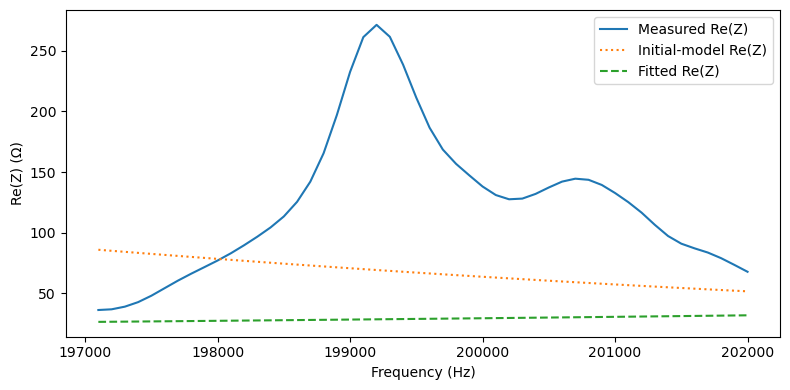

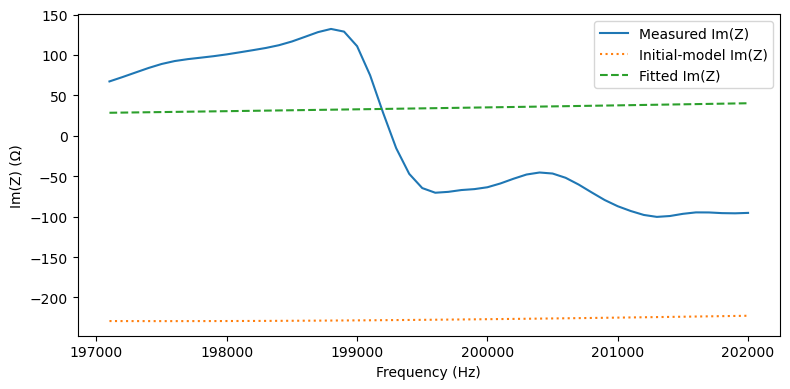


Derived fitted R/L/C:
R1 = 44.4733, L1 = 0.000267773, C1 = 2.73431e-09, C01 = 3.83591e-09
R2 = 12.8382, L2 = 0.000266636, C2 = 2.9338e-09, C02 = 3.83591e-09


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# ------------------------
# YOUR measured data variables must already exist:
# f_fit (Hz), Z_meas_fit (complex)
f_fit = f_fit
Z_meas = Z_meas_fit
# ------------------------

# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    """Given R, L, C (motional C), and C0, return fs (Hz), Q, Cm, C0"""
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- Two-DOF model using theta = [fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02] ---
def TwoDOF_bvd_theta(f, theta):
    fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02 = theta
    # convert to R,L,C
    R1, L1, C1, C01 = RLC_from_fsQCm(fs1, Q1, Cm1, C01)
    R2, L2, C2, C02 = RLC_from_fsQCm(fs2, Q2, Cm2, C02)

    w = 2*np.pi*f
    Z1 = R1 + 1j*w*L1 + 1.0/(1j*w*C1)
    Y1 = 1j*w*C01 + 1.0/Z1
    Z2 = R2 + 1j*w*L2 + 1.0/(1j*w*C2)
    Y2 = 1j*w*C02 + 1.0/Z2
    return 1.0 / (Y1 + Y2)

# --- weighted residuals ---
def residuals_theta(theta, f, Z_meas, peak_guesses=None, w_real=5.0, w_imag=1.0):
    Z_model = TwoDOF_bvd_theta(f, theta)

    # frequency weights (sum of Gaussians)
    W = np.ones_like(f, dtype=float)
    if peak_guesses is not None:
        for fc in peak_guesses:
            sigma = 0.03 * fc  # tightened to 3% band by default
            W += np.exp(-0.5*((f - fc)/sigma)**2)

    # scale each channel by robust scale (median abs)
    sR = np.median(np.abs(Z_meas.real)) + 1e-12
    sI = np.median(np.abs(Z_meas.imag)) + 1e-12

    rR = w_real * W * (Z_model.real - Z_meas.real) / sR
    rI = w_imag * W * (Z_model.imag - Z_meas.imag) / sI
    return np.concatenate([rR, rI])

# -------------------------
# Use your original R/L/C initial values to produce initial theta
# (these came from your message)
R1 = 550
C1 = 2.2109809489501582e-10
L1 = 0.0033115351895695922
C0_1 = 2.5e-9

R2 = 150
C2 = 2.5109809489501582e-10
L2 = 0.003115351895695922
C0_2 = 2.5e-9

# compute fs, Q, Cm from those
fs1_guess, Q1_guess, Cm1_guess, C01_guess = bvd_from_RLC(R1, L1, C1, C0_1)
fs2_guess, Q2_guess, Cm2_guess, C02_guess = bvd_from_RLC(R2, L2, C2, C0_2)

print("Derived initial guesses from your R,L,C:")
print(f"fs1 = {fs1_guess:.3f} Hz, Q1 = {Q1_guess:.3f}, Cm1 = {Cm1_guess:.3e}, C01 = {C01_guess:.3e}")
print(f"fs2 = {fs2_guess:.3f} Hz, Q2 = {Q2_guess:.3f}, Cm2 = {Cm2_guess:.3e}, C02 = {C02_guess:.3e}")

initial_theta = [fs1_guess, Q1_guess, Cm1_guess, C01_guess,
                 fs2_guess, Q2_guess, Cm2_guess, C02_guess]

# sensible bounds around these derived values
fs_pad = 0.15  # ±15% on frequency
lower = [
    (1-fs_pad)*fs1_guess, 1e-1, 1e-14, max(1e-13, C01_guess*0.1),
    (1-fs_pad)*fs2_guess, 1e-1, 1e-14, max(1e-13, C02_guess*0.1)
]
upper = [
    (1+fs_pad)*fs1_guess, 1e5, Cm1_guess*1e3, C01_guess*1e2,
    (1+fs_pad)*fs2_guess, 1e5, Cm2_guess*1e3, C02_guess*1e2
]

print("\nInitial theta and bounds:")
print("initial_theta =", initial_theta)
print("lower =", lower)
print("upper =", upper)

# Quick check: show how close initial model is to data (cost-like simple metric)
Z_init = TwoDOF_bvd_theta(f_fit, initial_theta)
init_err = np.mean(np.abs(Z_init - Z_meas))
print(f"\nInitial mean abs error (model vs measured): {init_err:.6e}")

# Now run the fit
result = least_squares(
    residuals_theta,
    initial_theta,
    args=(f_fit, Z_meas, [fs1_guess, fs2_guess], 5.0, 1.0),
    bounds=(lower, upper),
    method="trf",
    loss="soft_l1",
    ftol=1e-12, xtol=1e-12, gtol=1e-12,
    max_nfev=20000,
    verbose=2
)

print("\nFit cost:", result.cost)
labels = ["fs1","Q1","Cm1","C01","fs2","Q2","Cm2","C02"]
for name, val in zip(labels, result.x):
    print(f"{name} = {val}")

# Evaluate fitted model
Z_fit = TwoDOF_bvd_theta(f_fit, result.x)

# Plot measured vs fitted (real & imag)
plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.real, label="Measured Re(Z)")
plt.plot(f_fit, Z_init.real, ':', label="Initial-model Re(Z)")
plt.plot(f_fit, Z_fit.real, '--', label="Fitted Re(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Re(Z) (Ω)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(f_fit, Z_meas.imag, label="Measured Im(Z)")
plt.plot(f_fit, Z_init.imag, ':', label="Initial-model Im(Z)")
plt.plot(f_fit, Z_fit.imag, '--', label="Fitted Im(Z)")
plt.legend(); plt.xlabel("Frequency (Hz)"); plt.ylabel("Im(Z) (Ω)")
plt.tight_layout(); plt.show()

# Print derived R,L from fitted params for interpretability
fs1_f, Q1_f, Cm1_f, C01_f, fs2_f, Q2_f, Cm2_f, C02_f = result.x
R1_f, L1_f, C1_f, _ = RLC_from_fsQCm(fs1_f, Q1_f, Cm1_f, C01_f)
R2_f, L2_f, C2_f, _ = RLC_from_fsQCm(fs2_f, Q2_f, Cm2_f, C02_f)
print("\nDerived fitted R/L/C:")
print(f"R1 = {R1_f:.6g}, L1 = {L1_f:.6g}, C1 = {C1_f:.6g}, C01 = {C01_f:.6g}")
print(f"R2 = {R2_f:.6g}, L2 = {L2_f:.6g}, C2 = {C2_f:.6g}, C02 = {C02_f:.6g}")


In [66]:
# Example usage
folder_name = "2024-09-19-Dmg6"
sample_file = "sample_4.csv"
idx_low, idx_high = 14000, 20000


sample_data = get_sample_data(folder_name, sample_file)

f_band = sample_data["Frequency (Hz)"].values
Z_meas_real =  sample_data["Resistance (ohms)"].values
Z_meas_imag =  sample_data["Reactance (ohms)"].values

Z_meas_band = Z_meas_real + 1j*Z_meas_imag

# Restrict to the band of interest
f_fit = f_band[idx_low:idx_high]
Z_meas_fit = Z_meas_band[idx_low:idx_high]



In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares

# --- measured data ---
# f_fit (Hz), Z_meas_fit (complex)
f_fit = f_fit
Z_meas = Z_meas_fit

# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- generalized N-DOF BVD model ---
def NDOF_bvd_theta(f, theta):
    n = len(theta) // 4
    w = 2*np.pi*f
    Y_total = np.zeros_like(f, dtype=complex)

    for i in range(n):
        fs, Q, Cm, C0 = theta[i*4:(i+1)*4]
        R, L, C, C0 = RLC_from_fsQCm(fs, Q, Cm, C0)
        Z = R + 1j*w*L + 1/(1j*w*C)
        Y = 1j*w*C0 + 1/Z
        Y_total += Y

    return 1.0 / Y_total

# --- cost function for differential_evolution ---
def bvd_cost(theta, f, Z_meas):
    Z_model = NDOF_bvd_theta(f, theta)
    # weighted sum of squared errors (real + imag)
    err = np.abs(Z_model.real - Z_meas.real)**2 + np.abs(Z_model.imag - Z_meas.imag)**2
    return np.sum(err)

# -------------------------
# Example: arbitrary number of resonators
R_list = [550, 150, 300]      # add more as needed
L_list = [0.00331, 0.00312, 0.003]
C_list = [2.211e-10, 2.511e-10, 2.4e-10]
C0_list = [2.5e-9, 2.5e-9, 2.5e-9]

initial_theta = []
bounds = []
fs_pad = 0.15

## For loop

### Functions

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares


# --- helper: convert between parameterizations ---
def bvd_from_RLC(R, L, C, C0):
    """Given R, L, C (motional C), and C0, return fs (Hz), Q, Cm, C0"""
    w0 = 1.0 / np.sqrt(L * C)
    fs = w0 / (2*np.pi)
    Q = w0 * L / R
    return fs, Q, C, C0

def RLC_from_fsQCm(fs, Q, Cm, C0):
    w0 = 2*np.pi*fs
    Lm = 1.0 / (w0**2 * Cm)
    Rm = w0 * Lm / Q
    return Rm, Lm, Cm, C0

# --- Two-DOF model using theta = [fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02] ---
def TwoDOF_bvd_theta(f, theta):
    fs1, Q1, Cm1, C01, fs2, Q2, Cm2, C02 = theta
    # convert to R,L,C
    R1, L1, C1, C01 = RLC_from_fsQCm(fs1, Q1, Cm1, C01)
    R2, L2, C2, C02 = RLC_from_fsQCm(fs2, Q2, Cm2, C02)

    w = 2*np.pi*f
    Z1 = R1 + 1j*w*L1 + 1.0/(1j*w*C1)
    Y1 = 1j*w*C01 + 1.0/Z1
    Z2 = R2 + 1j*w*L2 + 1.0/(1j*w*C2)
    Y2 = 1j*w*C02 + 1.0/Z2
    return 1.0 / (Y1 + Y2)

# --- weighted residuals ---
def residuals_theta(theta, f, Z_meas, peak_guesses=None, w_real=5.0, w_imag=1.0):
    Z_model = TwoDOF_bvd_theta(f, theta)

    # frequency weights (sum of Gaussians)
    W = np.ones_like(f, dtype=float)
    if peak_guesses is not None:
        for fc in peak_guesses:
            sigma = 0.03 * fc  # tightened to 3% band by default
            W += np.exp(-0.5*((f - fc)/sigma)**2)

    # scale each channel by robust scale (median abs)
    sR = np.median(np.abs(Z_meas.real)) + 1e-12
    sI = np.median(np.abs(Z_meas.imag)) + 1e-12

    rR = w_real * W * (Z_model.real - Z_meas.real) / sR
    rI = w_imag * W * (Z_model.imag - Z_meas.imag) / sI
    return np.concatenate([rR, rI])

# --- cost function for differential_evolution ---
def bvd_cost(theta, f, Z_meas):
    Z_model = NDOF_bvd_theta(f, theta)
    # weighted sum of squared errors (real + imag)
    err = np.abs(Z_model.real - Z_meas.real)**2 + np.abs(Z_model.imag - Z_meas.imag)**2
    return np.sum(err)

# --- generalized N-DOF BVD model ---
def NDOF_bvd_theta(f, theta):
    n = len(theta) // 4
    w = 2*np.pi*f
    Y_total = np.zeros_like(f, dtype=complex)

    for i in range(n):
        fs, Q, Cm, C0 = theta[i*4:(i+1)*4]
        R, L, C, C0 = RLC_from_fsQCm(fs, Q, Cm, C0)
        Z = R + 1j*w*L + 1/(1j*w*C)
        Y = 1j*w*C0 + 1/Z
        Y_total += Y

    return 1.0 / Y_total


### Get data and set initial values

In [57]:
import pandas as pd
import numpy as np


# --- Build dataframe of your fitted parameters (you already had this pattern) ---
param_types = ["fs", "Q", "Cm", "C0"]
records = []
for fit in all_fits:
    rec = {}
    n_res = len(fit) // 4
    for i in range(n_res):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"]  = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)

# --- Derive motional L, motional R, and stiffness (1/Cm) for each resonator ---
derived = {}
for col in df.columns:
    if col.startswith("fs"):
        idx = col[2:]  # "1","2",...
        fs = df[f"fs{idx}"].values
        Q  = df[f"Q{idx}"].values
        Cm = df[f"Cm{idx}"].values

        w = 2*np.pi*fs
        Lm = 1.0 / (w**2 * Cm)            # proportional to mass
        Rm = 1.0 / (Q * w * Cm)            # proportional to damping
        k  = 1.0 / Cm                      # proportional to stiffness

        derived[f"m{idx}"] = Lm
        derived[f"c{idx}"] = Rm
        derived[f"k{idx}"] = k

df_phys = pd.DataFrame(derived)  # columns like m1,c1,k1,m2,c2,k2,...

# --- Correlate each physical parameter with weight ---
w = np.asarray(sample_weights)
corrs = {col: np.corrcoef(df_phys[col], w)[0,1] for col in df_phys.columns}
corrs_sorted = dict(sorted(corrs.items(), key=lambda kv: abs(kv[1]), reverse=True))

print("Correlation with sample weight (Pearson r):")
for k, v in corrs_sorted.items():
    print(f"{k}: {v:.3f}")

# Optional: also correlate raw fitted {fs,Q,Cm,C0} for comparison
corrs_fit = {col: np.corrcoef(df[col], w)[0,1] for col in df.columns}
corrs_fit_sorted = dict(sorted(corrs_fit.items(), key=lambda kv: abs(kv[1]), reverse=True))

print("\n(For reference) Correlation of fitted parameters with weight:")
for k, v in corrs_fit_sorted.items():
    print(f"{k}: {v:.3f}")


NameError: name 'all_fits' is not defined

In [ ]:
folder_names = ["HealthyDataset", "2024-08-22-Dmg1", "2024-08-23-Dmg2", "2024-08-26-Dmg3", "2024-08-29-Dmg4", "2024-09-18-Dmg5", "2024-09-19-Dmg6"]

sample_file = "sample_4.csv"

idx_low, idx_high = 14000, 20000

sample_weights = []
Z_meas_samples = []

for sampleFolders in folder_names:
    sample_data = get_sample_data(sampleFolders, sample_file)

    sample_weight = sample_data["delta_weight"].values
    f_band = sample_data["Frequency (Hz)"].values
    Z_meas_real =  sample_data["Resistance (ohms)"].values
    Z_meas_imag =  sample_data["Reactance (ohms)"].values

    Z_meas_band = Z_meas_real + 1j*Z_meas_imag

    # Restrict to the band of interest
    f_fit = f_band[idx_low:idx_high]
    Z_meas_fit = Z_meas_band[idx_low:idx_high]

    sample_weights.append(np.round(sample_weight[0],3))
    Z_meas_samples.append(Z_meas_fit)


all_fits = []
all_z_fits = []

# -------------------------
# Example: arbitrary number of resonators
R_list = [550, 150, 300]      # add more as needed
L_list = [0.00331, 0.00312, 0.003]
C_list = [2.211e-10, 2.511e-10, 2.4e-10]
C0_list = [2.5e-9, 2.5e-9, 2.5e-9]

initial_theta = []
bounds = []
fs_pad = 0.15



### Save data permenantly!

In [ ]:
import pickle

with open("Sample.pkl", "wb") as f:
    pickle.dump({"all_fits": all_fits, "all_z_fits": all_z_fits}, f)

## Load Data and analyse

   Mean_Mass
0   0.000000
1   1.789541
2   1.026863
3   0.725183
4   0.872624
5  -1.210950
6  -5.096787


<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
C:\Users\au585732\AppData\Local\Temp\ipykernel_33980\2305713267.py:7: SyntaxWarning: invalid escape sequence '\S'
  with open("Fitted_datasets\Sample4fits-drift-10-pop-20-maxiter-1000.pkl", "rb") as f:


ValueError: x and y must have the same length.

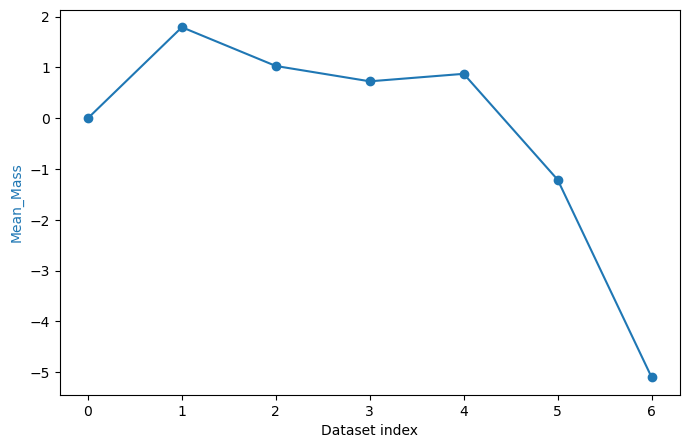

In [61]:
import pandas as pd
import pickle
import numpy as np
from scipy.stats import pearsonr

# Load fits
with open("Fitted_datasets\Sample4fits-drift-10-pop-20-maxiter-1000.pkl", "rb") as f:
    data = pickle.load(f)

all_fits = data["all_fits"]

# Build DataFrame
param_types = ["fs", "Q", "Cm", "C0"]
records = []

for fit in all_fits:
    rec = {}
    n_resonators = len(fit) // 4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"] = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)

# Compute mean motional mass per dataset
m_ref = 150  # 1 ng
fs_cols = [c for c in df.columns if c.startswith("fs")]

mass_per_dataset = []

for idx, row in df.iterrows():
    masses = []
    for fs_col in fs_cols:
        f_ref = df.loc[0, fs_col]   # reference frequency
        f_cur = row[fs_col]
        if f_cur > 0 and f_ref > 0:
            m = m_ref * (f_ref / f_cur)**2
            masses.append(m)
    if masses:
        mass_per_dataset.append(np.mean(masses))
    else:
        mass_per_dataset.append(np.nan)

df["Mean_Mass"] = mass_per_dataset

# Compute mass for each resonator
for i, fs_col in enumerate(fs_cols):
    df[f"Mass_{i+1}"] = m_ref * (df.loc[0, fs_col] / df[fs_col])**2

print(m_ref - df[["Mean_Mass"]])

fig, ax1 = plt.subplots(figsize=(8,5))

color1 = 'tab:blue'
ax1.set_xlabel('Dataset index')
ax1.set_ylabel('Mean_Mass', color=color1)
ax1.plot(m_ref - df["Mean_Mass"], marker='o', color=color1, label='Mean Mass')

# Plot individual resonator masses and compute correlations
colors = ['tab:green', 'tab:orange', 'tab:purple']
mass_corrs = []
for i, mass_col in enumerate([f"Mass_{j+1}" for j in range(len(fs_cols))]):
    corr_i, _ = pearsonr(m_ref - df[mass_col], sample_weights)
    mass_corrs.append(corr_i)
    ax1.plot(m_ref - df[mass_col], marker='.', linestyle='--', color=colors[i],
             label=f'Mass {i+1} (r={corr_i:.2f})')

ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Sample Weight', color=color2)
ax2.plot(sample_weights, marker='x', linestyle='--', color=color2, label='Sample Weight')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.grid(True)

# Correlation indicator (Pearson r) between mean mass loss and sample weight
corr, _ = pearsonr(m_ref - df["Mean_Mass"], sample_weights)
ax1.text(0.05, 0.95, f'Mean Corr={corr:.2f}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', color='black')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper right')
plt.show()



<Figure size 800x500 with 0 Axes>

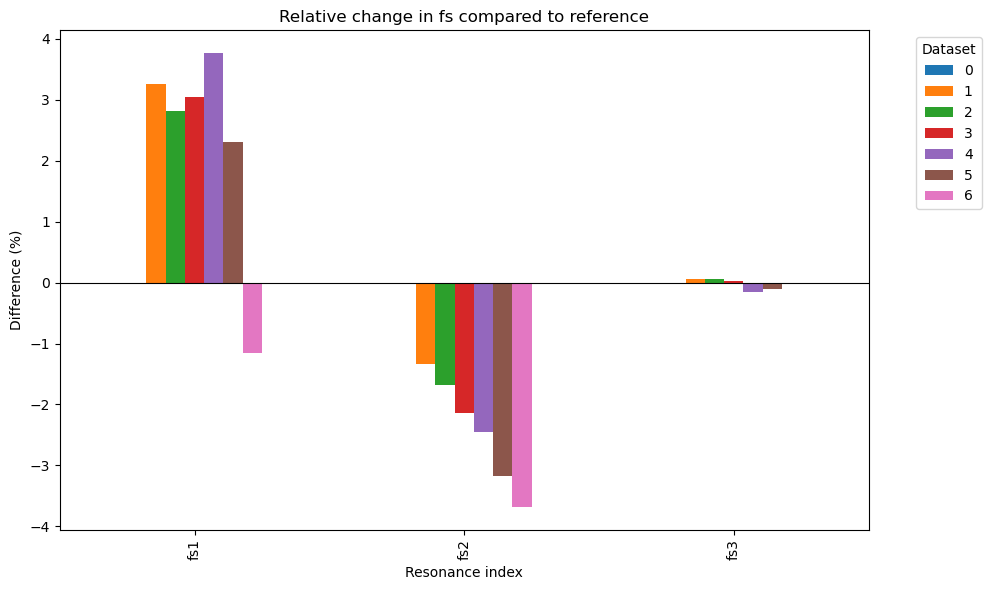

<Figure size 800x500 with 0 Axes>

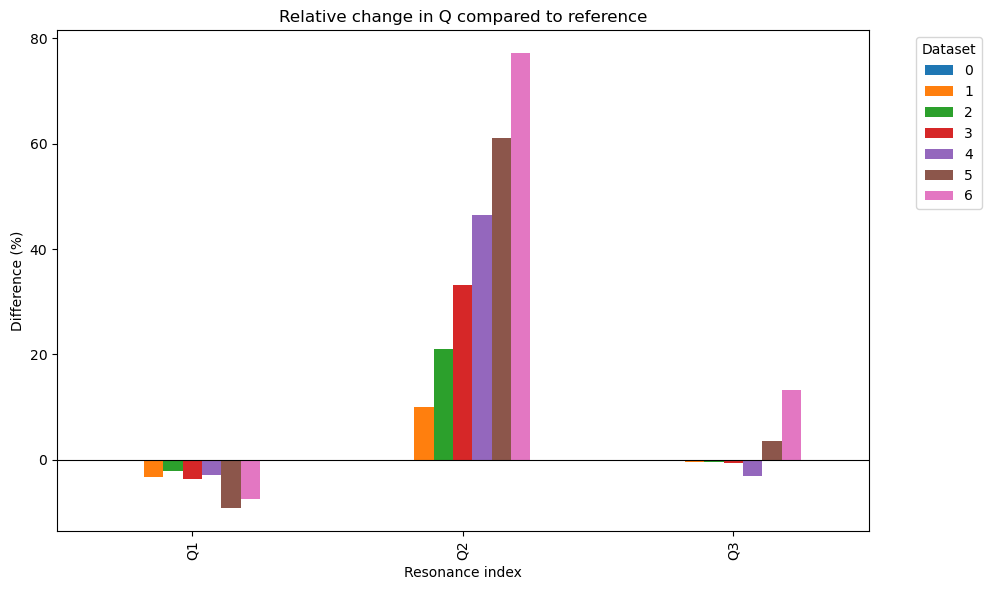

<Figure size 800x500 with 0 Axes>

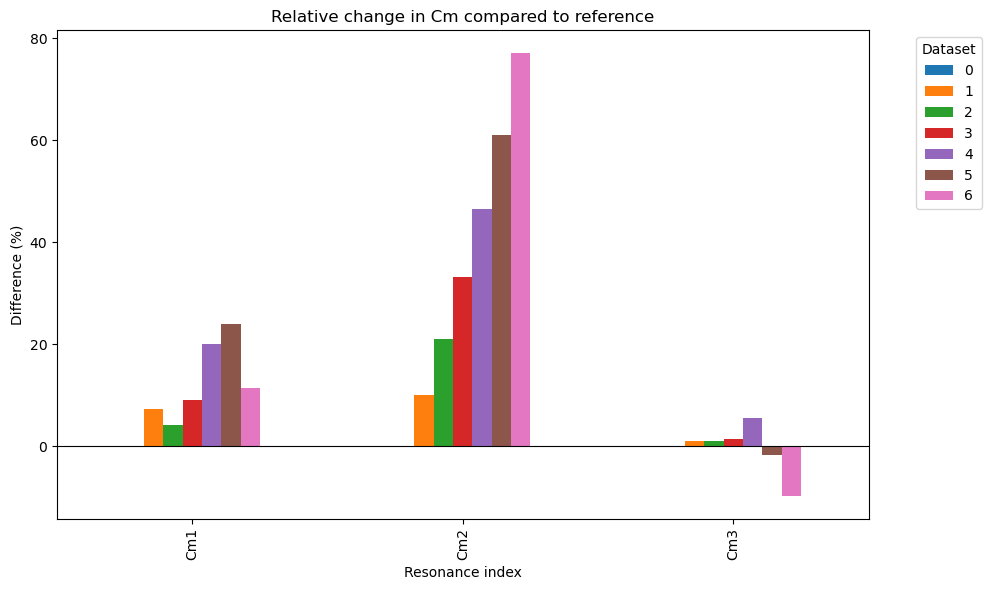

<Figure size 800x500 with 0 Axes>

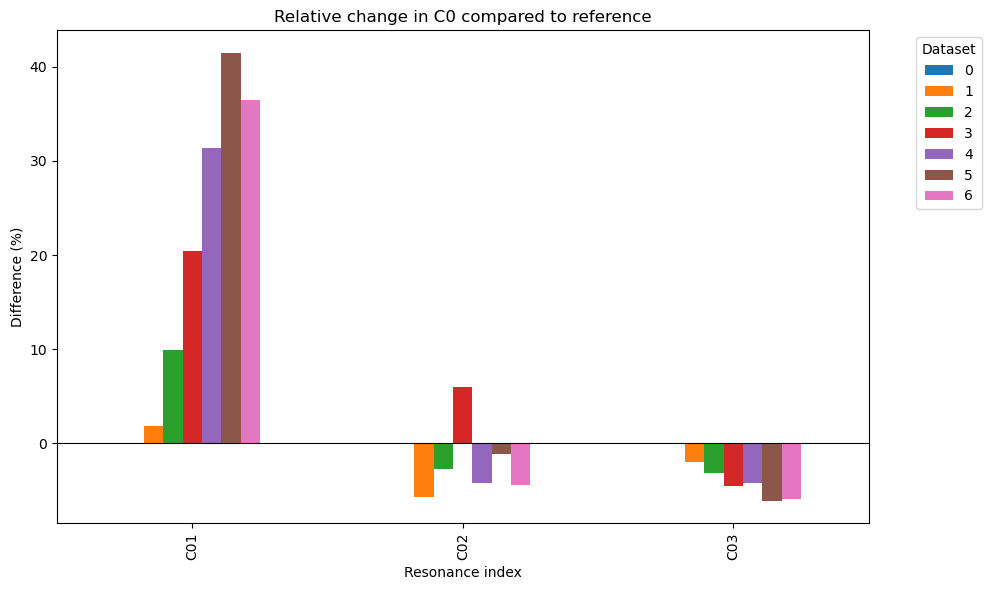

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Toggle here: "percent" or "absolute"
mode = "percent"

# Parameter units for labeling
param_units = {
    "fs": "Hz",
    "Q": "",        # dimensionless
    "Cm": "F",
    "C0": "F"
}

# Convert all_fits into a DataFrame
param_types = ["fs", "Q", "Cm", "C0"]
records = []

for fit in all_fits:
    rec = {}
    n_resonators = len(fit) // 4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"] = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)

# Compute differences
if mode == "percent":
    df_diff = (df - df.iloc[0]) / df.iloc[0] * 100
else:  # absolute difference
    df_diff = df - df.iloc[0]
    df_diff = df


# Plot each parameter type separately
for p_name in param_types:
    plt.figure(figsize=(8, 5))

    cols_param = [c for c in df_diff.columns if c.startswith(p_name)]
    df_diff[cols_param].T.plot(kind="bar", figsize=(10, 6))

    if mode == "percent":
        ylabel = "Difference (%)"
        title = f"Relative change in {p_name} compared to reference"
    else:
        unit = param_units[p_name]
        ylabel = f"Difference [{unit}]" if unit else "Difference"
        title = f"Absolute change in {p_name} compared to reference"

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Resonance index")
    plt.axhline(0, color="black", linewidth=0.8)
    plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


## Correlation with weights

Correlation of each parameter with sample weights:
fs1: 0.383
Q1: 0.937
Cm1: -0.702
C01: -0.884
fs2: 0.882
Q2: -0.928
Cm2: -0.928
C02: 0.237
fs3: 0.514
Q3: -0.770
Cm3: 0.681
C03: 0.840


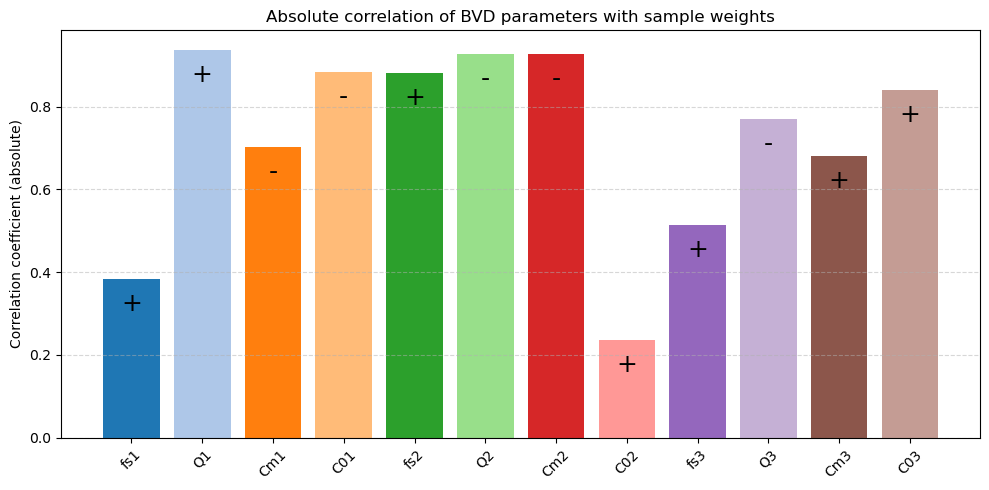

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Convert all_fits into a DataFrame (you already have this)
param_types = ["fs", "Q", "Cm", "C0"]
records = []

for fit in all_fits:
    rec = {}
    n_resonators = len(fit) // 4
    for i in range(n_resonators):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"] = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)

# Compute correlation with sample_weights
correlations = {}
for col in df.columns:
    corr = np.corrcoef(df[col], sample_weights)[0, 1]
    correlations[col] = corr

# Sort by strongest correlation
print("Correlation of each parameter with sample weights:")
for k, v in correlations.items():
    print(f"{k}: {v:.3f}")

# Plot all correlations once
cmap = plt.get_cmap('tab20')
bar_colors = [cmap(i) for i in range(len(correlations))]
plt.figure(figsize=(10, 5))
abs_corr_values = [abs(v) for v in correlations.values()]
bars = plt.bar(correlations.keys(), abs_corr_values, color=bar_colors)

# Annotate each bar with "+" or "-" for sign
for idx, (k, v) in enumerate(correlations.items()):
    sign = "+" if v >= 0 else "-"
    plt.text(idx, abs(v) - 0.09, sign, ha='center', va='bottom', fontsize=18, color='black')

plt.ylabel("Correlation coefficient (absolute)")
plt.title("Absolute correlation of BVD parameters with sample weights")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Parameter	    Physical meaning	                                                                                     Units
# fs	        Series resonance frequency of the resonator (where the impedance is minimum)	                         Hz
# Q	            Quality factor of the resonance (dimensionless) — indicates how sharp or damped the resonance is	      —
# Cm	        Motional capacitance (represents the resonating mass and elasticity)	                                 F (farads)
# C0	        Static or parallel capacitance of the resonator (represents the electrode 
#               capacitance or static capacitance across the resonator)                                                  F

LOOCV R^2 (relative params): -1.9687239319733667
Predicted weights: [16.61   1.102 -1.744 -3.878 -5.915 -6.519 -9.718]
Actual weights: [ 0.   -1.2  -1.6  -1.6  -3.55 -9.65 -9.85]


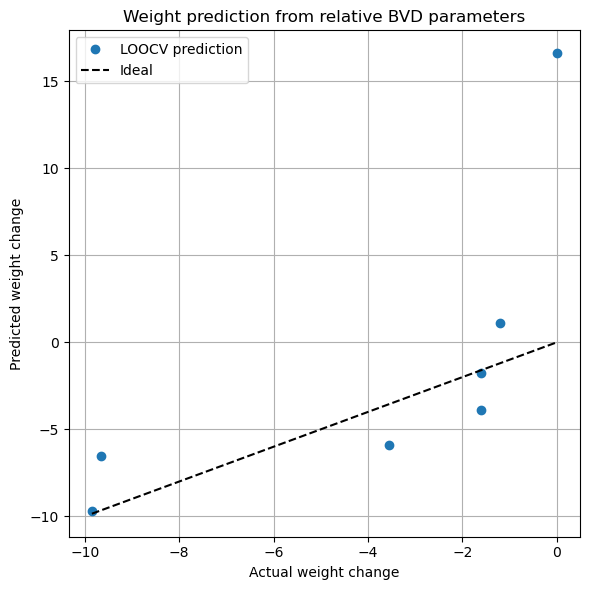

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import LeaveOneOut

# Convert weights to numpy
y = np.array(sample_weights, dtype=float)

# Choose features (example: fs2, Q2, Cm2, add more if useful)
features = ["fs2", "Q2", "Cm2"]

# Convert to numpy and subtract reference (dataset 0)
X = df[features].values
X_rel = X - X[0]   # relative features

# Leave-One-Out CV
loo = LeaveOneOut()
y_pred_loo = np.zeros_like(y, dtype=float)

model = Ridge(alpha=1e-3)  # Ridge regression (tunable alpha)
for train_idx, test_idx in loo.split(X_rel):
    X_train, X_test = X_rel[train_idx], X_rel[test_idx]
    y_train = y[train_idx]
    model.fit(X_train, y_train)
    y_pred_loo[test_idx] = model.predict(X_test)

# Performance
r2_loo = 1 - np.sum((y - y_pred_loo)**2) / np.sum((y - np.mean(y))**2)
print("LOOCV R^2 (relative params):", r2_loo)
print("Predicted weights:", np.round(y_pred_loo, 3))
print("Actual weights:", y)

# Plot results
plt.figure(figsize=(6,6))
plt.plot(y, y_pred_loo, "o", label="LOOCV prediction")
plt.plot([min(y), max(y)], [min(y), max(y)], "k--", label="Ideal")
plt.xlabel("Actual weight change")
plt.ylabel("Predicted weight change")
plt.title("Weight prediction from relative BVD parameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\au585732\AppData\Local\Temp\ipykernel_24900\1567530588.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corrs.index, y=corrs.values, palette="coolwarm")


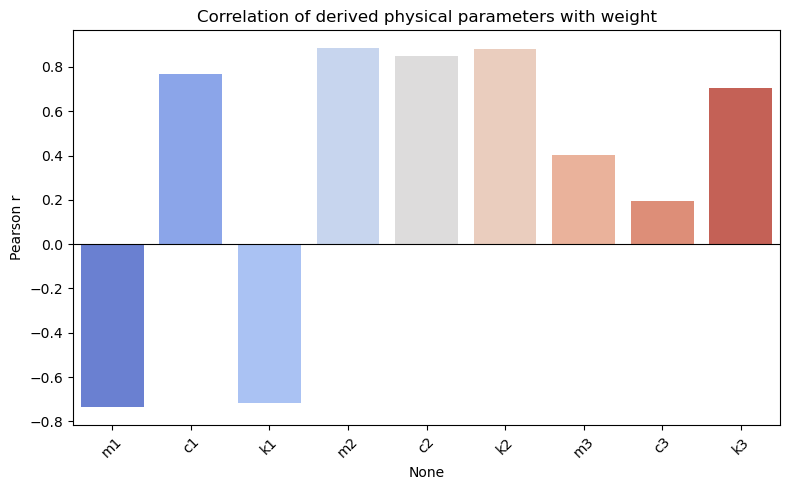

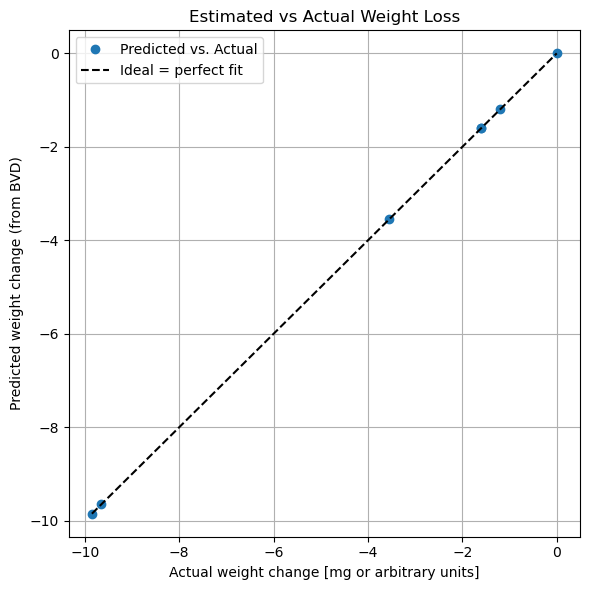

R^2 (model vs. actual): 0.9999999999844144


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


# --- Build dataframe from all_fits (same as before) ---
param_types = ["fs", "Q", "Cm", "C0"]
records = []
for fit in all_fits:
    rec = {}
    n_res = len(fit) // 4
    for i in range(n_res):
        fs, Q, Cm, C0 = fit[i*4:(i+1)*4]
        rec[f"fs{i+1}"] = fs
        rec[f"Q{i+1}"]  = Q
        rec[f"Cm{i+1}"] = Cm
        rec[f"C0{i+1}"] = C0
    records.append(rec)

df = pd.DataFrame(records)

# --- Derive physical parameters: mass (Lm), damping (Rm), stiffness (1/Cm) ---
derived = {}
for col in df.columns:
    if col.startswith("fs"):
        idx = col[2:]  # "1","2",...
        fs = df[f"fs{idx}"].values
        Q  = df[f"Q{idx}"].values
        Cm = df[f"Cm{idx}"].values

        w = 2*np.pi*fs
        Lm = 1.0 / (w**2 * Cm)       # ∝ mass
        Rm = 1.0 / (Q * w * Cm)      # ∝ damping
        k  = 1.0 / Cm                # ∝ stiffness

        derived[f"m{idx}"] = Lm
        derived[f"c{idx}"] = Rm
        derived[f"k{idx}"] = k

df_phys = pd.DataFrame(derived)

# --- Correlation heatmap ---
corrs = df_phys.corrwith(pd.Series(sample_weights))
plt.figure(figsize=(8,5))
sns.barplot(x=corrs.index, y=corrs.values, palette="coolwarm")
plt.title("Correlation of derived physical parameters with weight")
plt.ylabel("Pearson r")
plt.xticks(rotation=45)
plt.axhline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()

# --- Predict weight from physical parameters (linear regression) ---
X = df_phys.values
y = sample_weights

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Compare predicted vs. actual
plt.figure(figsize=(6,6))
plt.plot(y, y_pred, "o", label="Predicted vs. Actual")
plt.plot([min(y), max(y)], [min(y), max(y)], "k--", label="Ideal = perfect fit")
plt.xlabel("Actual weight change [mg or arbitrary units]")
plt.ylabel("Predicted weight change (from BVD)")
plt.title("Estimated vs Actual Weight Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print R^2 for goodness of fit
print("R^2 (model vs. actual):", model.score(X, y))


In [ ]:
df.head()

,fs1,Q1,Cm1,C01,fs2,Q2,Cm2,C02,fs3,Q3,Cm3,C03
0,183280.977187,13.775263,9.681881e-11,1.778280e-09,152843.132029,67557.018127,2.267478e-11,7.322255e-10,215698.046375,2.801458,1.117165e-10,1.701671e-10
1,183378.341520,13.842960,9.678876e-11,1.669975e-09,150932.420873,74312.665659,2.494226e-11,8.013569e-10,221076.706144,2.711884,1.190620e-10,1.734759e-10
2,183390.473347,13.851514,9.675044e-11,1.625277e-09,150409.413585,81743.803157,2.743648e-11,8.559376e-10,220129.997944,2.746997,1.155169e-10,1.666279e-10
3,183318.438162,13.825119,9.714874e-11,1.699899e-09,149723.866190,89918.104859,3.018013e-11,7.792310e-10,220642.233066,2.704734,1.210263e-10,1.808440e-10
4,183006.944777,13.474018,1.010284e-10,1.679266e-09,149254.988897,98909.910325,3.319814e-11,8.483550e-10,222163.699359,2.725124,1.331289e-10,1.701045e-10


In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
import numpy as np

# Pick just one column, e.g. Q1
X = df[["Cm2"]].values
y = np.array(sample_weights, dtype=float)

loo = LeaveOneOut()
y_pred = np.zeros_like(y)

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train = y[train_idx]
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred[test_idx] = model.predict(X_test)

r2 = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)
print("LOOCV R^2 (Q1 only):", r2)
print("Predicted:", y_pred)
print("Actual:", y)


LOOCV R^2 (Q1 only): 0.7610027860763503
Predicted: [ 1.64884792 -0.09866984 -1.99851509 -3.92181495 -5.79540618 -6.55256283
 -9.42544305]
Actual: [ 0.   -1.2  -1.6  -1.6  -3.55 -9.65 -9.85]
